### IMPORTS

In [283]:
from functions import get_data_path
from functions import get_voice_paths
from functions import get_sample_path
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pylab
from PIL import Image
import torchvision
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models

In [87]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

In [46]:
import librosa.display

### LOAD DATA

In [263]:
data_path, config = get_data_path('eng')

In [4]:
data = get_voice_paths(data_path)

In [5]:
data['age'][data['age']=='teens'] = '10\'s'
data['age'][data['age']=='twenties'] = '20\'s'
data['age'][data['age']=='thirties'] = '30\'s'
data['age'][data['age']=='fourties'] = '40\'s'
data['age'][data['age']=='fifties'] = '50\'s'
data['age'][data['age']=='sixties'] = '60\'s'
data['age'][data['age']=='seventies'] = '70\'s'
data['age'][data['age']=='eighties'] = '80\'s'
data['age'][data['age']=='nineties'] = '90\'s'

C:\Users\Nowaq\AppData\Local\Temp/ipykernel_49436/276306525.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['age'][data['age']=='twenties'] = '20\'s'
C:\Users\Nowaq\AppData\Local\Temp/ipykernel_49436/276306525.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['age'][data['age']=='thirties'] = '30\'s'
C:\Users\Nowaq\AppData\Local\Temp/ipykernel_49436/276306525.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['age

<AxesSubplot:>

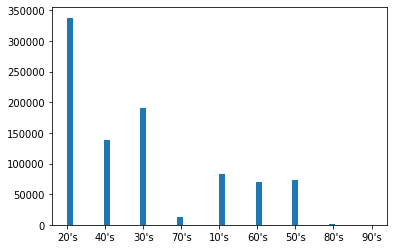

In [68]:
data['age'].hist(grid=False, bins=50)

<AxesSubplot:>

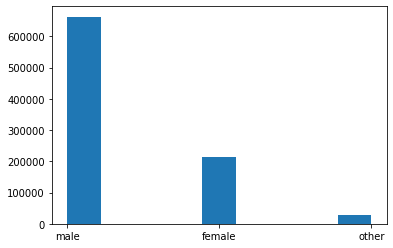

In [6]:
data['gender'].hist(grid=False, bins=9)

### LIBROSA TESTING

LOADING DATA

In [112]:
sample_name = data['path'][47]

In [113]:
sample_name

'common_voice_en_22338655.mp3'

In [114]:
file_path = get_sample_path(sample_name, data_path, config)

In [115]:
file_path

'D:/Dokumenty/INZYNIERKA/data/eng-data/clips/common_voice_en_22338655.mp3'

In [116]:
audio_sample, sr = librosa.load(file_path)
audio_sample

c:\users\nowaq\pycharmprojects\inz-project\inz-venv\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

MELSPECTROGRAM

In [117]:
spect = librosa.feature.melspectrogram(audio_sample, sr=sr)
S_db = librosa.power_to_db(spect, ref=np.max)

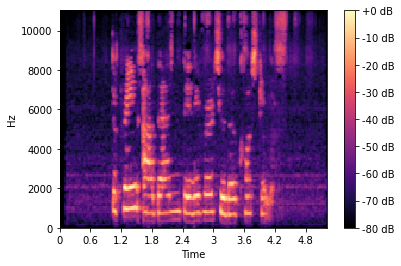

In [118]:
fig, ax = plt.subplots()
img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax)
plt.colorbar(img, ax=ax, format="%+2.f dB")

MFCC

In [171]:
mfccs = librosa.feature.mfcc(audio_sample, sr=sr, n_mfcc=20)

In [172]:
mfccs[:,:50].shape

(20, 50)

In [226]:
mfccs.shape

(20, 225)

In [173]:
mfccs.shape

(20, 225)

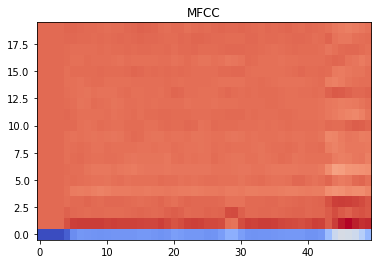

In [178]:
ig, ax = plt.subplots()
cax = ax.imshow(mfccs[:,:50], interpolation='nearest', cmap=cm.coolwarm, origin='lower', aspect='auto')
ax.set_title('MFCC')
#Showing mfcc_data
plt.show()

SPLITTING MFCCS

In [190]:
hop = 30
n_samples = 50
inputs = list()
for i in range(0, mfccs.shape[1], hop):
    if i < mfccs.shape[1]:
        if i+hop <= mfccs.shape[1]:
            inputs.append(mfccs[:,i:i+n_samples])
        else:
            inputs.append(mfccs[:,mfccs.shape[1]-n_samples:])
            break

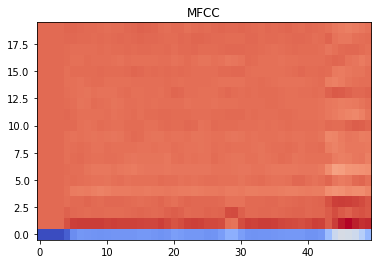

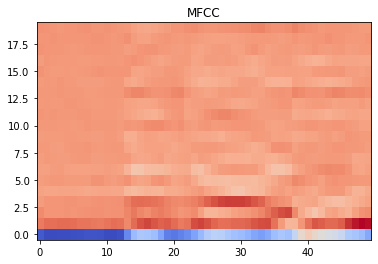

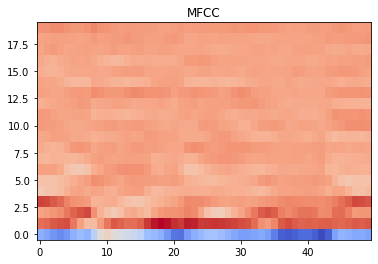

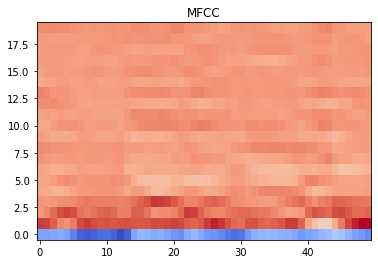

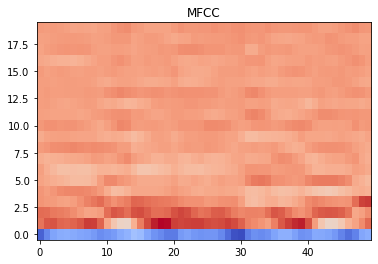

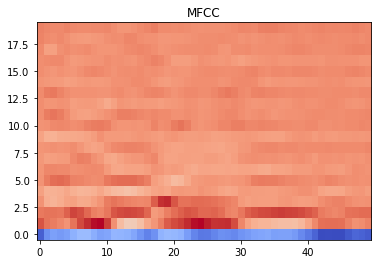

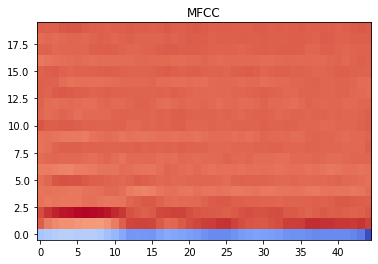

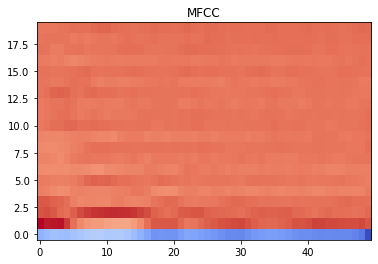

In [191]:
for i in inputs:
    ig, ax = plt.subplots()
    cax = ax.imshow(i, interpolation='nearest', cmap=cm.coolwarm, origin='lower', aspect='auto')
    ax.set_title('MFCC')
    #Showing mfcc_data
    plt.show()

### TORCH TESTING

CREATE DATASETS

In [220]:
data[:1000000000]

,client_id,path,age,gender
10,10,common_voice_en_18295850.mp3,20's,male
47,47,common_voice_en_22338655.mp3,20's,female
62,62,common_voice_en_18277778.mp3,40's,male
68,68,common_voice_en_21943181.mp3,20's,male
70,70,common_voice_en_20586574.mp3,20's,male
...,...,...,...,...
1425779,65708,common_voice_en_27214904.mp3,50's,male
1425780,65708,common_voice_en_27214953.mp3,50's,male
1425781,65708,common_voice_en_27214957.mp3,50's,male
1425782,65708,common_voice_en_27214975.mp3,50's,male


In [200]:
ages = ("10's", "20's", "30's", "40's", "50's", "60's")
genders = ('male', 'female')

In [222]:
n_test = 2000
n_train = 20000
test_data = pd.DataFrame(columns=data.columns)
train_data = pd.DataFrame(columns=data.columns)
for age in ages:
    age_filter = (data['age'] == age)
    for gender in genders:
        gender_filter = (data[age_filter]['gender'] == gender)
        filtered_data = data[age_filter][gender_filter]
        train=filtered_data.sample(frac=1)[:int(n_train/2)]
        train_data = pd.concat([train_data, train])
        filtered_data = filtered_data.drop(train.index)
        test=filtered_data.sample(frac=1)[:int(n_test/2)]
        test_data = pd.concat([test_data, test])

In [246]:
train_data

,client_id,path,age,gender
1032428,65415,common_voice_en_18343736.mp3,10's,male
693772,63645,common_voice_en_22270108.mp3,10's,male
476799,60260,common_voice_en_24078155.mp3,10's,male
278025,52388,common_voice_en_162845.mp3,10's,male
639372,63067,common_voice_en_18841283.mp3,10's,male
...,...,...,...,...
1366623,65706,common_voice_en_20437201.mp3,60's,female
336080,55498,common_voice_en_278371.mp3,60's,female
706902,63769,common_voice_en_19945572.mp3,60's,female
1277741,65688,common_voice_en_19887661.mp3,60's,female


CREATE DATALOADER

In [273]:
def collate_fn(batch):
    batch = batch.reset_index(drop=True)
    data_path, config = get_data_path('eng')
    out_mfccs = list()
    out_gender = list()
    targets = list()
    file_paths = [get_sample_path(i[1]['path'], data_path, config) for i in batch.iterrows()]
    for i, path in enumerate(file_paths):
        mfccs = librosa.feature.mfcc(audio_sample, sr=sr, n_mfcc=20)
        hop = 30
        n_samples = 50
        for i in range(0, mfccs.shape[1], hop):
            if i < mfccs.shape[1]:
                if i+hop <= mfccs.shape[1]:
                    out_mfccs.append(mfccs[:,i:i+n_samples])
                    targets.append(batch.loc[i,'age'])
                    gender.append(batch.loc[i,'gender'])
                else:
                    out_mfccs.append(mfccs[:,mfccs.shape[1]-n_samples:])
                    targets.append(batch.loc[i,'age'])
                    gender.append(batch.loc[i,'gender'])
                    break
    out_mfccs = torch.tensor(np.array(out_mfccs))
    out_gender = torch.tensor(np.array(out_gender))
    targets = torch.tensor(np.array(targets))
    
    return out_mfccs, out_gender, targets

In [276]:
train_dl = DataLoader(train_data, batch_size=50, shuffle=False, collate_fn=collate_fn)
test_dl = DataLoader(test_data, batch_size=50, shuffle=False, collate_fn=collate_fn)

MODEL SIECI

In [286]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5, stride=1, padding=0)
        self.resnet18 = models.resnet18(pretrained=True)
        self.lin1 = nn.Linear(1000, 120)
        self.lin2 = nn.Linear(120, 50)
        self.lin3 = nn.Linear(50, 6)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.resnet18(x)
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        return x
    
net = Net()
net

Net(
  (conv): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
  (resnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNor

In [287]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
epochs = 20

for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dl, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, gender, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print('[%d/5] loss: %.3f' %
          (epoch+1 ,  running_loss / 2000))
    running_loss = 0.0

print('Finished Training')